In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_curve, auc as sk_auc
from itertools import cycle
from sklearn.preprocessing import label_binarize

In [3]:
#Load Data Set 
df = pd.read_csv(r"C:\Users\User\Desktop\python data science\codeAlpha\Iris Flower Classification\Iris.csv")

In [12]:
X = df.drop('Species', axis=1)
y_text = df['Species']
le = LabelEncoder()
y = le.fit_transform(y_text)
target_names = le.classes_
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [13]:
df.isna().sum()

Id               0
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

In [16]:
# Initialize and train models
models = {
    'LogisticRegression': LogisticRegression(max_iter=2000, random_state=42),
    'RandomForestClassifier': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBClassifier': XGBClassifier(enable_categorical=True, eval_metric='mlogloss', random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=target_names)
    auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    
    results[name] = {'accuracy': accuracy, 'report': report, 'auc': auc, 'cm': cm, 'y_pred_proba': y_pred_proba}
    
    

In [23]:
print(accuracy)
print(results[name])
print(report)
print(auc)
print(cm)

1.0
{'accuracy': 1.0, 'report': '                 precision    recall  f1-score   support\n\n    Iris-setosa       1.00      1.00      1.00        10\nIris-versicolor       1.00      1.00      1.00        10\n Iris-virginica       1.00      1.00      1.00        10\n\n       accuracy                           1.00        30\n      macro avg       1.00      1.00      1.00        30\n   weighted avg       1.00      1.00      1.00        30\n', 'auc': 1.0, 'cm': array([[10,  0,  0],
       [ 0, 10,  0],
       [ 0,  0, 10]]), 'y_pred_proba': array([[0.9888286 , 0.00617178, 0.00499962],
       [0.00498409, 0.00431388, 0.99070203],
       [0.00430298, 0.9913932 , 0.00430381],
       [0.0055745 , 0.98884994, 0.00557557],
       [0.9888286 , 0.00617178, 0.00499962],
       [0.0105781 , 0.9788417 , 0.01058015],
       [0.9888286 , 0.00617178, 0.00499962],
       [0.9888286 , 0.00617178, 0.00499962],
       [0.00498409, 0.00431388, 0.99070203],
       [0.01192631, 0.9761451 , 0.01192862],
     

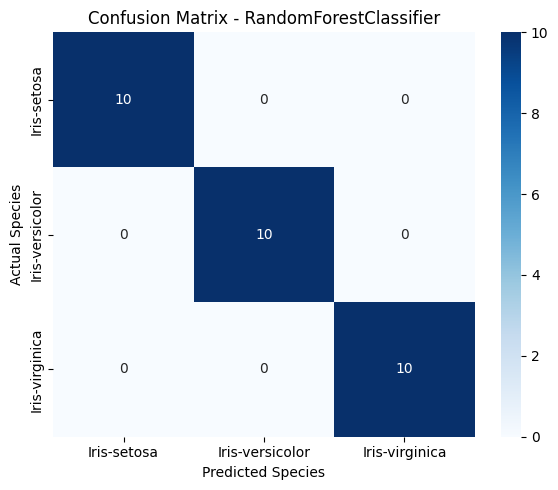

In [25]:
# Assuming 'results', 'target_names' are defined from the model training step
best_model_name = 'RandomForestClassifier'

plt.figure(figsize=(6, 5))
sns.heatmap(results[best_model_name]['cm'], annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual Species')
plt.xlabel('Predicted Species')
plt.tight_layout()
plt.savefig('confusion_matrix_rf.png')
plt.show()
plt.close()

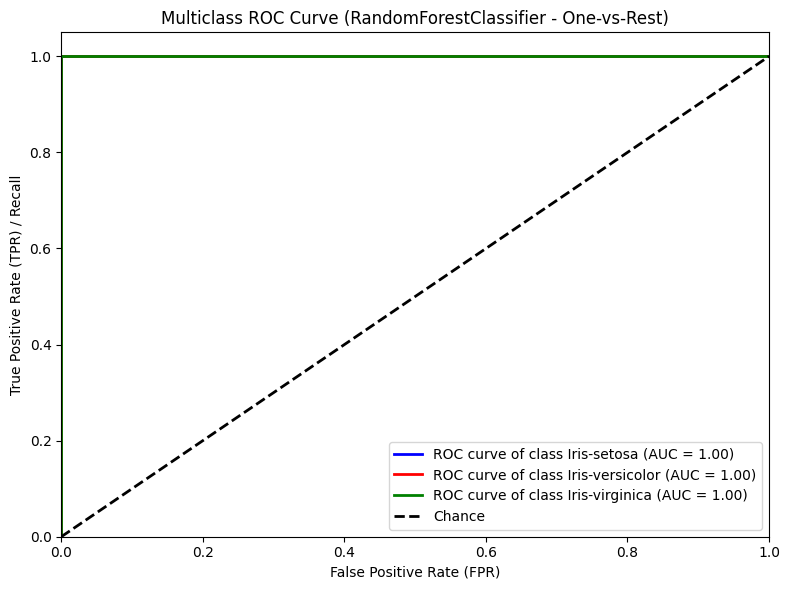

In [26]:
# Binarize the output for ROC curve plotting (One-vs-Rest)
n_classes = len(target_names)
y_test_bin = label_binarize(y_test, classes=range(n_classes))

# Get probabilities for RF
y_pred_proba_rf = results['RandomForestClassifier']['y_pred_proba']

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc_class = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba_rf[:, i])
    roc_auc_class[i] = sk_auc(fpr[i], tpr[i])

# Aggregate all false positive rates to calculate Micro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    # Using np.interp for interpolation
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["micro"] = all_fpr
tpr["micro"] = mean_tpr
roc_auc_class["micro"] = sk_auc(fpr["micro"], tpr["micro"])


# Plotting the ROC Curve
plt.figure(figsize=(8, 6))
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (AUC = {1:0.2f})'.format(target_names[i], roc_auc_class[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) / Recall')
plt.title('Multiclass ROC Curve (RandomForestClassifier - One-vs-Rest)')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('multiclass_roc_curve.png')
plt.show()
plt.close()

Conclusion:- RandomForestClassifier model is the best-performing model for this specific Iris dataset among the models we tested (Logistic Regression, XGBoost).